In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertTokenizer, BertForSequenceClassification

# specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Zhafran Pratama\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Zhafran Pratama\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\Zhafran Pratama\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
c:\Users\Zhafran Pratama\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/dataset.csv")

# Cleaning dataset
import re

def clean_text(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = re.sub('\W', ' ', sentence)
    sentence = re.sub('\s+', ' ', sentence)
    sentence = sentence.strip(' ')
    return sentence

for i, sentence in enumerate(df['text']):
    try:
        df['text'][i] = clean_text(sentence)
    except:
        pass

df.head()

,label,text
0,Lifestyle,celebrate the new year together at finnsbeachclub
1,Lifestyle,friendship bestie bali beachclubbali beachclub...
2,Lifestyle,nah kan bandel sih
3,Otomotif,dmotovlog rs125 apriliars125
4,Music,ilovesoundnya


In [3]:
category_list = ['Lifestyle', 'Otomotif', 'Music', 'Beauty', 'Fashion', 'Traveling', 'Food', 'Finance', 'Parenting', 'Technology', 'Health', 'Gigs Worker', 'Homedecor', 'Gamers', 'Sport', 'Reviewer', 'Kpop', 'Politik']

df['label'] = df['label'].replace(category_list,range(len(category_list)))
df.head()

,label,text
0,0,celebrate the new year together at finnsbeachclub
1,0,friendship bestie bali beachclubbali beachclub...
2,0,nah kan bandel sih
3,1,dmotovlog rs125 apriliars125
4,2,ilovesoundnya


In [4]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


val_text, _, val_labels, _ = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

<AxesSubplot:>

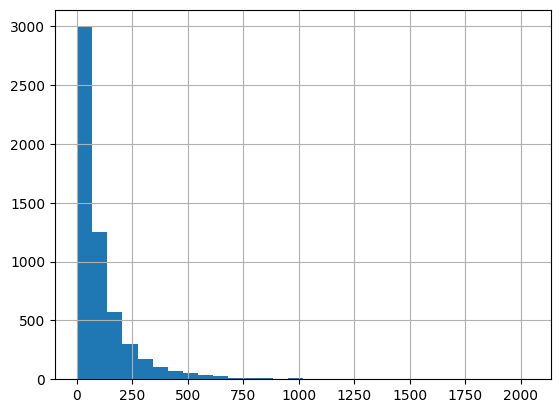

In [5]:
# Average amount of characters in 1 text
seq_len = [len(i) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [6]:
# Tokenize and encode sequences in the TRAINING set
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 100,
    padding='longest',
    truncation=True
)

# Tokenize and encode sequences in the VALIDATION set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 100,
    padding='longest',
    truncation=True
)

In [7]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [8]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [9]:
import platform

# pass the pre-trained BERT to our define architecture
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=18)
# push the model to GPU
model = model.to(device)
if device == "cuda":
    print("Using device:", torch.cuda.get_device_name(0), flush=True)
elif device == "cpu":
    print("Using device:", platform.processor(), flush=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# optimizer from hugging face transformers
from torch.optim import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

In [11]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
# class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                 
                                    )

print("Class Weights:",class_weights)

Class Weights: [ 0.67297169  5.92976939  3.11166117  0.16878506  1.40931739  1.63686343
  0.24903152  2.43626184  1.32049486  1.65409357  0.72082059 24.17521368
  4.5547504   3.49197531  1.95203589  2.2773752  28.57070707 14.28535354]


In [12]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.CrossEntropyLoss()

# number of training epochs
epochs = 10

In [13]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds.logits, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # append the model predictions
    total_preds.append(preds)

    # calculate the accuracy for this batch
    _, pred_labels = torch.max(preds.logits, dim=1)
    accuracy = torch.sum(pred_labels == labels).item() / labels.size(0)
    total_accuracy += accuracy

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  avg_accuracy = total_accuracy / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate([total_preds], axis=0)

  #returns the loss and predictions
  return avg_loss, avg_accuracy, total_preds

In [14]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds.logits,labels)

      total_loss = total_loss + loss.item()

      total_preds.append(preds)

    # calculate the accuracy for this batch
    _, pred_labels = torch.max(preds.logits, dim=1)
    accuracy = torch.sum(pred_labels == labels).item() / labels.size(0)
    total_accuracy += accuracy

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)
  avg_accuracy = total_accuracy / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate([total_preds], axis=0)

  return avg_loss, avg_accuracy, total_preds

In [15]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
train_accs = []
valid_accs = []

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_acc, total_pred = train()
    #evaluate model
    valid_loss, valid_acc, total_pred = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        model.save_pretrained("../ml-models")
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
  
    print(f'\nTraining Accuracy: {train_acc:.3f}')
    print(f'Training Loss: {train_loss:.3f}')
    print(f'Validation Accuracy: {valid_acc:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    354.
  Batch   100  of    354.
  Batch   150  of    354.
  Batch   200  of    354.
  Batch   250  of    354.
  Batch   300  of    354.
  Batch   350  of    354.

Evaluating...
  Batch    50  of     76.

Training Accuracy: 0.670
Training Loss: 1.215
Validation Accuracy: 0.777
Validation Loss: 0.823

 Epoch 2 / 10
  Batch    50  of    354.
  Batch   100  of    354.
  Batch   150  of    354.
  Batch   200  of    354.
  Batch   250  of    354.
  Batch   300  of    354.
  Batch   350  of    354.

Evaluating...
  Batch    50  of     76.

Training Accuracy: 0.831
Training Loss: 0.617
Validation Accuracy: 0.810
Validation Loss: 0.678

 Epoch 3 / 10
  Batch    50  of    354.
  Batch   100  of    354.
  Batch   150  of    354.
  Batch   200  of    354.
  Batch   250  of    354.
  Batch   300  of    354.
  Batch   350  of    354.

Evaluating...
  Batch    50  of     76.

Training Accuracy: 0.895
Training Loss: 0.387
Validation Accuracy: 0.821
Validation Loss: 0

In [16]:
# Free cache gpu memory
torch.cuda.empty_cache()